|feature|dimension|memo|
|:-:|:-:|:-:|
|adx|-|DI = price_diff / price_diff|
|adxr|-|ma(adx)|
|rsi|-||
|aroon_down/up|-|days after new high|
|aroon_osc|-|aroon_up - aroon_down|
|cci|roc|price_diff / ma(price_diff)|
|cmo|-|2 * rsi - 100. essentially same as rsi|
|dx|-||
|mfi|-|money flow = dollar. money flow ratio = dollar ver of volume ratio. (ftx's volume is dollar. so, it is meaningless to use mfi directly)|
|trix|roc||
|atr|price_diff||
|natr|roc||
|obv_rsi|-|rsi(obv)|
|ad_rsi|-|rsi(ad)|
|macdsignal|price_diff||
|stoch|-||
|stochf|-||
|stochrsi|-||
|ultosc|-|price_diff / price_diff|

- roc: rate of price change

good features

- dimension less
- bounded
- distribution is independent from symbol and time (price, std, price unit, volume)

feature rule

- dimension less
- bounded [-1, 1], [0, 1]



In [186]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import seaborn as sns

import src
from src.ml_utils import (
    fetch_ohlcv,
    visualize_result,
    normalize_position,
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
symbols = 'BTC'.split(',')
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=False, price_type=None, interval_sec=5 * 60)
df.to_pickle('/tmp/df_interval300_price_type_none_btc.pkl')
display(df)

,,op,hi,lo,cl,volume,execution_start_at
timestamp,symbol,,,,,,
2019-07-20 12:35:00+00:00,BTC,10564.25,10573.25,10560.50,10564.25,6.365293e+05,2019-07-20 12:40:00+00:00
2019-07-20 12:40:00+00:00,BTC,10564.25,10567.00,10550.25,10556.50,1.207911e+06,2019-07-20 12:45:00+00:00
2019-07-20 12:45:00+00:00,BTC,10556.50,10568.00,10525.50,10540.25,2.228462e+06,2019-07-20 12:50:00+00:00
2019-07-20 12:50:00+00:00,BTC,10540.25,10551.75,10529.50,10541.00,2.662661e+06,2019-07-20 12:55:00+00:00
2019-07-20 12:55:00+00:00,BTC,10542.25,10545.00,10528.25,10539.50,1.063855e+06,2019-07-20 13:00:00+00:00
...,...,...,...,...,...,...,...
2022-09-16 08:15:00+00:00,BTC,19709.00,19725.00,19630.00,19665.00,1.982325e+07,2022-09-16 08:20:00+00:00
2022-09-16 08:20:00+00:00,BTC,19665.00,19722.00,19665.00,19707.00,6.889978e+06,2022-09-16 08:25:00+00:00
2022-09-16 08:25:00+00:00,BTC,19708.00,19708.00,19679.00,19680.00,5.593809e+06,2022-09-16 08:30:00+00:00


In [197]:
import numba
import gc

df = pd.read_pickle('/tmp/df_interval300_price_type_none_btc.pkl')
# display(df)
# df['ret'] = (df.groupby('symbol')['cl'].shift(-48) / df.groupby('symbol')['cl'].shift(0) - 1).fillna(0)
df['ret'] = (df.groupby('symbol')['cl'].shift(-49) / df.groupby('symbol')['cl'].shift(-1) - 1).fillna(0)
# df['ret'] = (df.groupby('symbol')['cl'].shift(-12 * 8 - 1) / df.groupby('symbol')['cl'].shift(-1) - 1).fillna(0)
# df['ret'] = (df.groupby('symbol')['cl'].shift(-7) / df.groupby('symbol')['cl'].shift(-1) - 1).fillna(0)
# df = pd.read_pickle('/tmp/df_horizon96_price_type_none.pkl')

# based on 20220910_eda

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

@numba.njit
def future_value_in_abs_diff_scale(x, sum_abs_diff, interpolate=False, max_days=0):
    y = x.copy()
    y[:] = np.nan
    for i in range(x.shape[0]):
        sum = 0.0
        for j in range(i + 1, x.shape[0]):
            sum += np.abs(x[j] - x[j - 1])
            if sum >= sum_abs_diff or (max_days and j - i >= max_days):
                if interpolate:
                    t = (sum - sum_abs_diff) / np.abs(x[j] - x[j - 1])
                    y[i] = x[j - 1] * (1 - t) + x[j] * t
                else:
                    y[i] = x[j]
                break
    return y

def calc_features(df):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    if False:
        beta_window = 24 * 30
        # beta_window = 24 * 7

        df['beta_weight'] = 1
        # df['beta_weight'] = 1 + df.groupby('symbol')['volume'].transform(lambda x: x.rolling(24 * 7, 1).mean())

        def beta_mean(col):
            return (df[col] * df['beta_weight']).groupby('timestamp').transform('mean') / df.groupby('timestamp')['beta_weight'].transform('mean')

        # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
        df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')

        # wrong
        # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

        df['beta'] = (
            (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
            / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
        ).fillna(0).clip(0.1, 2.0)
        # df['beta'] = 1.0
    
    if False:
        # ret_mean = df.groupby('timestamp')['ret'].transform('mean')
        # ret_mean = beta_mean('ret')
        dfs = [
            df.drop(columns=get_feature_columns(df)),
            # (unbiased_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            # (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
        for col in get_feature_columns(df):
            # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

            feature_mean = beta_mean(col)
            # feature_mean = df.groupby('timestamp')[col].transform('mean')
            dfs += [
                (2 * unbiased_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
                (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
            ]
        df = pd.concat(dfs, axis=1)

        dfs = [df]
        for col in get_feature_columns(df):
            if '_symbolbeta' not in col:
                continue
            dfs += [
                (2 * unbiased_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
            ]
        df = pd.concat(dfs, axis=1)

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    # for t in [12, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16, 24]:
    for t in [2, 4, 8, 16, 32]: #, 64, 128]:
    # for t in [8, 24, 48]:
        feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
        feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
        feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

        feature_stoch_k, feature_stoch_d = stoch(t)
        feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
        feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

        feature_stochf_k, feature_stochf_d = stochf(t)
        feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
        feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

        feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
        feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
        feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

        feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))
        
        ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

        dfs += [
            adx(t).rename('feature_adx_{}'.format(t)),
            adxr(t).rename('feature_adxr_{}'.format(t)),
            feature_rsi,
            rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
            rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
            aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
            aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
            aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
            # cci(t).rename('feature_cci_{}'.format(t)),
            # cmo(t).rename('feature_cmo_{}'.format(t)),
            dx(t).rename('feature_dx_{}'.format(t)),
            mfi(t).rename('feature_mfi_{}'.format(t)),
            # trix(t).rename('feature_trix_{}'.format(t)),
            # feature_integ_std,
            # feature_std,
            # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
            # feature_mom,
            # atr(t).rename('feature_atr_{}'.format(t)),
            # natr(t).rename('feature_natr_{}'.format(t)),
            range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
            # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
            # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
            # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
            volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
            range_pos(t).rename('feature_range_pos_{}'.format(t)),
            range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
            # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
            obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
            ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
            # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
            # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
            feature_stoch_k,
            feature_stoch_d,
            (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
            (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
            feature_stochf_k,
            feature_stochf_d,
            (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
            (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
            feature_stochrsi_k,
            feature_stochrsi_d,
            (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
            (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
            ultosc(t).rename('feature_ultosc_{}'.format(t)),
            volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
            skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
            # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
            (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
            feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
            (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
            # dimension less but not bounded
            # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
            # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
            # zscore(t).rename('feature_zscore_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
            # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
            # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
        ]

    df = pd.concat(dfs, axis=1)
    
    # df['ln_cl_future'] = future_value_in_abs_diff_scale(df['ln_cl'].values, 0.1)
    # df['ret'] = (np.exp(df['ln_cl_future'].shift(-1)) / df['cl'].shift(-1) - 1).fillna(0)
    
    if True:
        dfs = [
            df,
            # df.drop(columns=get_feature_columns(df)),
            (df['ret'].iloc[::-1].rolling(120, 1).rank(pct=True) - 0.5).iloc[::-1].rename('ret_rr'),

        ]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col].rolling(120, 1).rank(pct=True) - 0.5).rename(col + '_rr'),
        #     ]
        df = pd.concat(dfs, axis=1)
    
    return df

df = df.dropna()
df = calc_features(df)
df[get_feature_columns(df)] = df[get_feature_columns(df)].astype('float32')
gc.collect()
print('finished')

finished


In [198]:
def fast_corr(df):
    return pd.DataFrame(np.corrcoef(df.values.T), index=df.columns, columns=df.columns)

corr = fast_corr(df[['ret', 'ret_rr'] + get_feature_columns(df)])
corr_spearman = fast_corr(df[['ret', 'ret_rr'] + get_feature_columns(df)].rank())
gc.collect()

# corr = df[['ret', 'ret_rank'] + get_feature_columns(df)].corr()
# corr_spearman = df[['ret', 'ret_rank'] + get_feature_columns(df)].corr(method='spearman')

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0

In [199]:
def preprocess_corr(df, th=0.99):
    # corr = fast_corr(df[get_feature_columns(df)])
    corr = fast_corr(df[get_feature_columns(df)].rank())
    removed_features = []
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if np.abs(corr.iloc[i, j]) > th:
                removed_features.append(corr.columns[j])
    return df.loc[:, ~df.columns.isin(removed_features)]

print('pearsonr')
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if np.abs(corr.iloc[i, j]) > 0.99:
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j], corr_spearman.iloc[i, j])
     
print('spearmanr')
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if np.abs(corr_spearman.iloc[i, j]) > 0.99:
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j], corr_spearman.iloc[i, j])

gc.collect()

pearsonr
feature_obv_rsi_16 feature_volume_ratio_16 0.9990923834866752 0.999687623576124
feature_obv_rsi_2 feature_volume_ratio_2 0.9927133639343104 0.9920773608044158
feature_obv_rsi_32 feature_volume_ratio_32 0.9995507493675578 0.999861047083219
feature_obv_rsi_4 feature_volume_ratio_4 0.9957492853347188 0.9964690807947019
feature_obv_rsi_8 feature_volume_ratio_8 0.99765553959343 0.9987999451634928
feature_range_pos_16 feature_stochf_k_16 0.9999644674718629 0.9999650614570271
feature_range_pos_2 feature_stochf_k_2 0.9998236680184368 0.9998137665074954
feature_range_pos_32 feature_stochf_k_32 0.9999316955778748 0.9999306294947544
feature_range_pos_4 feature_stochf_k_4 0.9999073268846843 0.9999084479138584
feature_range_pos_8 feature_stochf_k_8 0.999968034214099 0.999970253107969
feature_range_pos_rank_2 feature_stochrsi_k_2 -0.9932245378227019 -0.9932130271819365
feature_range_pos_rank_2 feature_stochrsi_k_4 -0.9931692154305111 -0.9931616027931015
feature_range_pos_rank_2 feature_stoc

0

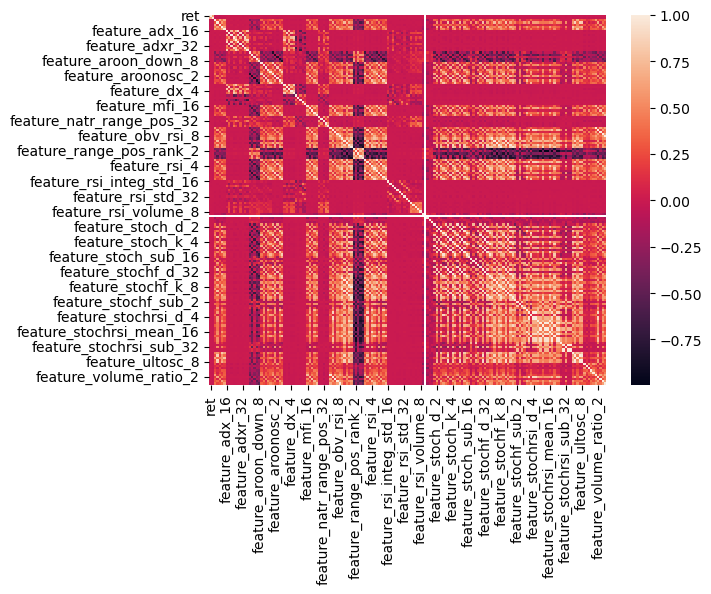

,ret,feature_rsi_32
feature_ad_rsi_32,-0.027956,0.438333
feature_ad_rsi_16,-0.021313,0.253715
feature_ultosc_32,-0.017922,0.314158
feature_ad_rsi_8,-0.015771,0.169031
feature_volume_corr_16,-0.013228,0.516221
feature_ultosc_16,-0.013041,0.202411
feature_ad_rsi_4,-0.011783,0.121232
feature_volume_corr_32,-0.011291,0.534454
feature_rsi_integ_std_16,-0.010033,-0.012134
feature_ultosc_8,-0.008535,0.137785


8291

In [200]:
sns.heatmap(corr)
plt.show()

# corr['feature_rsi_24_abs'] = corr['feature_rsi_24'].abs()
# sns.heatmap(corr.sort_values('feature_rsi_24_abs')[['ret', 'ret_rank', 'feature_rsi_24']])
# plt.show()
# display(corr.sort_values('feature_rsi_24_abs')[['ret', 'ret_rank', 'feature_rsi_24']])
# display(corr.sort_values('ret')[['ret', 'feature_rsi_32']])
display(corr.sort_values('ret')[['ret', 'feature_rsi_32']])
gc.collect()

In [201]:
def validate_df2(df):
    df = df[['ret'] + get_feature_columns(df)]
    for col in df.columns:
        print(col, df[col].min(), df[col].max(), df[col].mean(), df[col].median())

validate_df2(df)
gc.collect()

ret -0.3530686841210473 0.3445718138907621 0.00021851929215349438 0.00019745285813010938
feature_ad_rsi_16 -1.0 1.0 0.010126807726919651 0.010584520176053047
feature_ad_rsi_2 -1.0 1.0 0.000461494637420401 0.0
feature_ad_rsi_32 -1.0 0.9951807260513306 0.009831847622990608 0.011124120093882084
feature_ad_rsi_4 -1.0 1.0 0.006498291157186031 0.008434674702584743
feature_ad_rsi_8 -1.0 1.0 0.009663044475018978 0.011973641812801361
feature_adx_16 0.0 0.8509351015090942 0.2480059564113617 0.2218281328678131
feature_adx_2 0.0 1.0 0.6422519683837891 0.6410565376281738
feature_adx_32 0.0 0.6657813191413879 0.1896650642156601 0.16719767451286316
feature_adx_4 0.0 0.9984954595565796 0.45111340284347534 0.42522722482681274
feature_adx_8 0.0 0.9552004933357239 0.33027318120002747 0.30231815576553345
feature_adxr_16 0.0 0.8135225176811218 0.2479976862668991 0.22537751495838165
feature_adxr_2 0.0 1.0 0.6422526240348816 0.6412101984024048
feature_adxr_32 0.0 0.6553747057914734 0.18964290618896484 0.1701

0

shape (332236, 171)
isfinite True
min -1.0
max 1.4142135381698608


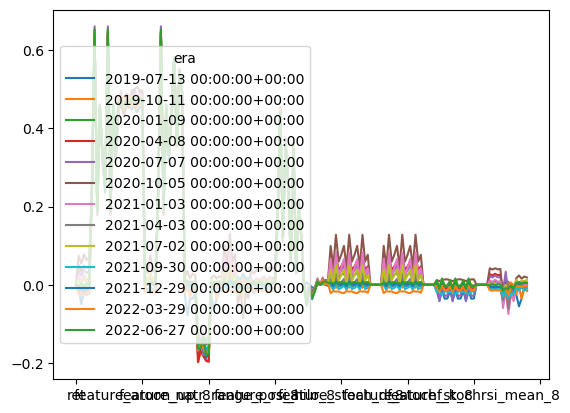

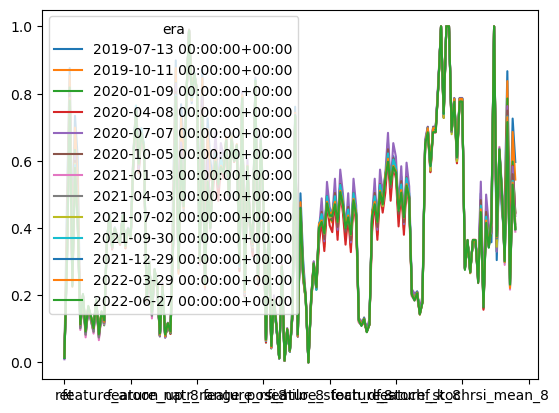

,mean_std,std_std
feature_range_pos_32,0.042241,0.019599
feature_stochf_k_32,0.042106,0.019620
feature_stochf_mean_32,0.042081,0.021594
feature_stoch_k_32,0.042077,0.022801
feature_stochf_d_32,0.042057,0.022778
feature_stoch_mean_32,0.042055,0.022534
feature_stoch_d_32,0.042033,0.022658
feature_range_pos_16,0.034204,0.014617
feature_stochf_k_16,0.034096,0.014589
feature_stochf_mean_16,0.034094,0.016076


,mean_std,std_std
feature_obv_rsi_8,0.010419,0.065407
feature_volume_ratio_8,0.010191,0.063868
feature_obv_rsi_4,0.010912,0.063233
feature_volume_ratio_4,0.009341,0.062739
feature_ad_rsi_8,0.028203,0.056784
feature_obv_rsi_16,0.012524,0.055820
feature_mfi_8,0.011238,0.055796
feature_volume_ratio_16,0.012325,0.054818
feature_mfi_4,0.014967,0.053330
feature_ad_rsi_16,0.029874,0.052163


shape (332236, 135)
isfinite True
min -1.0
max 1.4142135381698608


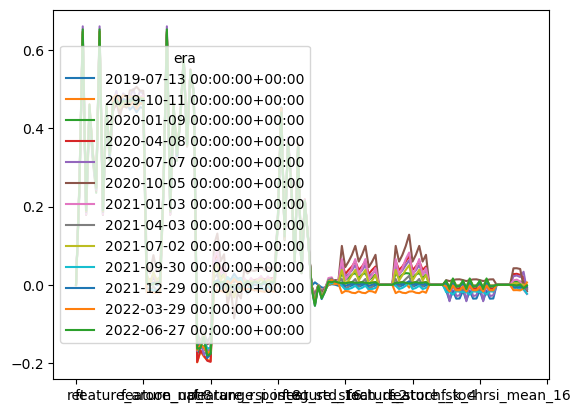

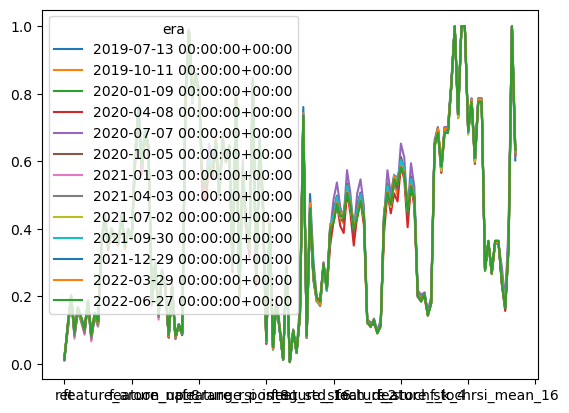

,mean_std,std_std
feature_range_pos_32,0.042241,0.019599
feature_stochf_k_32,0.042106,0.019620
feature_range_pos_16,0.034204,0.014617
feature_stochf_k_16,0.034096,0.014589
feature_stochf_mean_16,0.034094,0.016076
feature_stochf_d_16,0.034092,0.016651
feature_stoch_k_16,0.034092,0.016652
feature_stoch_mean_16,0.034085,0.017470
feature_stoch_d_16,0.034078,0.017480
feature_range_pos_rank_32,0.029522,0.008438


,mean_std,std_std
feature_stoch_mean_2,0.017729,0.019769
feature_stochf_k_32,0.042106,0.019620
feature_range_pos_32,0.042241,0.019599
feature_range_pos_4,0.021288,0.019463
feature_stochf_k_4,0.021312,0.019450
feature_stoch_d_2,0.017729,0.019386
feature_ultosc_8,0.015966,0.018953
feature_stochf_mean_4,0.021312,0.018498
feature_stochf_d_4,0.021311,0.018195
feature_stoch_k_4,0.021310,0.018195


In [202]:
def validate_df(df, g='symbol'):
    df = df[['ret'] + get_feature_columns(df)].copy()
    print('shape', df.shape)
    print('isfinite {}'.format(np.all(np.isfinite(df.values))))
    print('min {}'.format(np.min(df.values)))
    print('max {}'.format(np.max(df.values)))

    df['era'] = df.index.get_level_values('timestamp').floor('90D')

    # display(df.groupby(g).describe())

    df.groupby(g).mean().transpose().plot()
    plt.show()
    df.groupby(g).std().transpose().plot()
    plt.show()

    display(pd.concat([
        df.groupby(g).mean().std().rename('mean_std'),
        df.groupby(g).std().std().rename('std_std'),
    ], axis=1).sort_values('mean_std', ascending=False).iloc[:30])

    display(pd.concat([
        df.groupby(g).mean().std().rename('mean_std'),
        df.groupby(g).std().std().rename('std_std'),
    ], axis=1).sort_values('std_std', ascending=False).iloc[:30])

def preprocess_df(df, g='symbol', mean_th=0.05, std_th=0.02):
    df2 = df[get_feature_columns(df)].copy()

    df2['era'] = df2.index.get_level_values('timestamp').floor('90D')

    mean_std = df2.groupby(g).mean().std()
    std_std = df2.groupby(g).std().std()
    std = df2.std()

    excluded_feature = mean_std[mean_std > mean_th].index.tolist() + std_std[std_std > std_th].index.tolist() + std[std == 0.0].index.tolist()

    df = df.loc[:, ~df.columns.isin(excluded_feature)]

    return df

# validate_df(df)
# validate_df(preprocess_df(df))
validate_df(df, g='era')
validate_df(preprocess_df(df, g='era'), g='era')

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


PearsonRResult(statistic=0.03489588679422208, pvalue=6.234808017358336e-46)
SpearmanrResult(correlation=0.038964548629742884, pvalue=7.807199111997943e-57)
0.01617111650491461 0.000306709181183666
PearsonRResult(statistic=0.0288187316511502, pvalue=7.216650379636222e-32)
SpearmanrResult(correlation=0.028455084834205828, pvalue=4.127327164054298e-31)


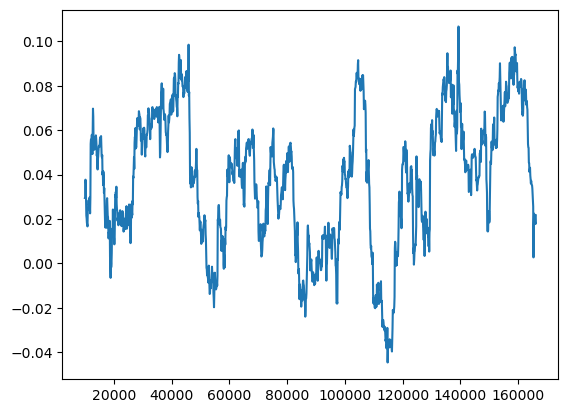

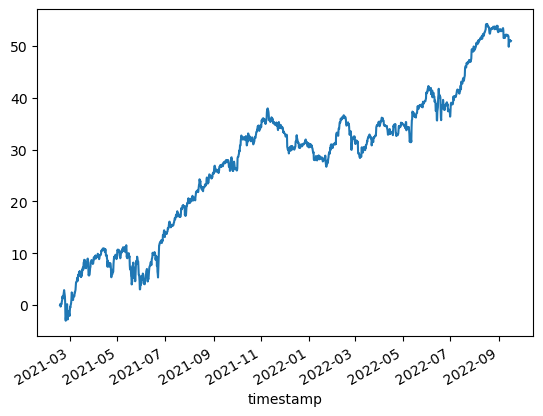

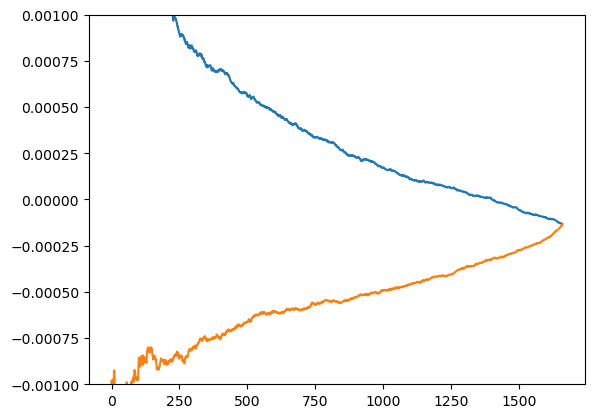

,imp
feature_adxr_32,355.881102
feature_rsi_std_32,235.282940
feature_rsi_integ_std_32,230.950882
feature_ad_rsi_32,220.837982
feature_adx_32,207.732036
feature_volume_corr_32,204.137917
feature_adxr_16,196.990943
feature_stoch_d_32,163.884417
feature_aroonosc_32,161.047169
feature_mfi_32,150.714710


In [206]:
import lightgbm as lgb
from scipy.stats import pearsonr, spearmanr
import random
import gc
from sklearn.pipeline import Pipeline
from sklearn.cluster import FeatureAgglomeration

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.cluster import FeatureAgglomeration

# double sharpe
def feature_selector_score_func(X, y):
    ret = X * y.reshape(-1, 1)
    # ret = pd.DataFrame(ret, index=X.index)
    ret = pd.DataFrame(ret)
    # ret = ret.groupby('timestamp').sum()
    agg = ret.rolling(24 * 30 * 10)
    sharpe = agg.mean() / agg.std()
    score = (sharpe.mean() / sharpe.std()).abs().fillna(0).values
    plt.plot(score)
    plt.show()
    return score

gc.collect()

def process(df):
    df = df.copy()
    
    if False:
        dfs = [
            df,
            # df.loc[:, ~df.columns.isin(features)],
        ]
        features = get_feature_columns(df)
        for col in features:
            col2 = random.choice(features)
            col3 = random.choice(features)
            dfs += [
                (df[col] ** 2).rename(col + '_sqr'),
                # df[col].abs().rename(col + '_abs'),
                # (df[col].abs() - 0.25).abs().rename(col + '_abs2'),
                (df[col] * df[col2]).rename(col + '_mul_' + col2),
                # (df[col] / (0.6 + df[col2])).rename(col + '_div_' + col2),
                # (df[col] * df[col2] * df[col3]).rename(col + '_mul_' + col2 + '_mul_' + col3),
            ]
        df = pd.concat(dfs, axis=1)
    
    df = preprocess_corr(df, th=0.99)
    # df = preprocess_df(df, g='era', mean_th=0.03, std_th=0.03)
    # df = preprocess_df(df, g='symbol', mean_th=0.05, std_th=0.02)

    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        # colsample_bytree=0.1,
        # boosting_type='rf',
        # subsample=0.5,
        # subsample_freq=3,
        # extra_trees=True,
        random_state=1,
        n_jobs=-1,
        importance_type="gain",
    )
    # model = Ridge(alpha=1e5)
    
    # model = Pipeline([
    #     # ('feat_agglo', FeatureAgglomeration(n_clusters=int(df.shape[1] * 0.5))),
    #     ('select', SelectPercentile(
    #         score_func=feature_selector_score_func,
    #         percentile=5,
    #     )),
    #     ('model', model)
    # ])

    # display(df.iloc[:20])

    features = get_feature_columns(df)
    # features = [x for x in features if '_rr' not in x]
    test_min_idx = int(df.shape[0] * 0.5)
    
    for i in range(1):
        model2 = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.1,
            # colsample_bytree=0.1,
            # boosting_type='rf',
            # subsample=0.5,
            # subsample_freq=3,
            # extra_trees=True,
            random_state=1,
            n_jobs=-1,
            importance_type="gain",
        )
        model2.fit(df[features], np.arange(df.shape[0]))
        importance = pd.DataFrame(model2.feature_importances_, index=features, columns=['imp']).sort_values('imp', ascending=False)
        features = [x for x in features if x not in importance.index[:len(features) // 16]]

    if False:
        dfs = [
            df,
            # df.loc[:, ~df.columns.isin(features)],
        ]
        for col in features:
            col2 = random.choice(features)
            col3 = random.choice(features)
            dfs += [
                (df[col] ** 2).rename(col + '_sqr'),
                # df[col].abs().rename(col + '_abs'),
                # (df[col].abs() - 0.25).abs().rename(col + '_abs2'),
                # (df[col] * df[col2]).rename(col + '_mul_' + col2),
                # (df[col] / (0.6 + df[col2])).rename(col + '_div_' + col2),
                # (df[col] * df[col2] * df[col3]).rename(col + '_mul_' + col2 + '_mul_' + col3),
            ]
            features += [col + '_sqr']
        df = pd.concat(dfs, axis=1)
    df = df.dropna()
    # features = get_feature_columns(df)

    # model.fit(df[features].iloc[:test_min_idx], df['ret_rank'].iloc[:test_min_idx])
    # model.fit(df[features].iloc[:test_min_idx], df['ret_beta'].iloc[:test_min_idx])
    # model.fit(df[features].iloc[:test_min_idx], df['ret'].iloc[:test_min_idx])
    y = df['ret'].iloc[:test_min_idx]
    # y = df['ret_rr'].iloc[:test_min_idx]
    # model.fit(df[features].iloc[:test_min_idx], np.sign(y), model__sample_weight=np.abs(y))
    model.fit(df[features].iloc[:test_min_idx], np.sign(y), sample_weight=np.abs(y))
    # model.fit(df[features].iloc[:test_min_idx], y)

    df.loc[df.index[test_min_idx:], 'y_pred'] = model.predict(df[features].iloc[test_min_idx:])
    df2 = df.iloc[test_min_idx:].reset_index()
    print(pearsonr(df2['ret'], df2['y_pred']))
    print(spearmanr(df2['ret'], df2['y_pred']))
    print(df2['ret'].std(), (df2['ret'] * np.sign(df2['y_pred'])).mean())
    print(pearsonr(df2['ret_rr'], df2['y_pred']))
    print(spearmanr(df2['ret_rr'], df2['y_pred']))
    # print(pearsonr(df2['ret_beta'], df2['y_pred']))
    # print(spearmanr(df2['ret_beta'], df2['y_pred']))
    df2['ret'].rolling(10000).corr(df2['y_pred']).dropna().iloc[::100].plot()
    plt.show()
    df2['position'] = np.sign(df2['y_pred'])
    # df2['position'] = unbiased_rank(df2.groupby('timestamp')['y_pred']) - 0.5
    normalize_position(df2)
    df2 = df2.set_index('timestamp')
    (df2['ret'] * df2['position']).dropna().cumsum().iloc[::100].plot()
    plt.show()
    
    plt.plot(df2.reset_index().sort_values('y_pred', ascending=False).expanding()['ret'].mean().values[::100])
    plt.plot(df2.reset_index().sort_values('y_pred', ascending=True).expanding()['ret'].mean().values[::100])
    plt.ylim(-0.001, 0.001)
    plt.show()

    importance = pd.DataFrame(model.feature_importances_, index=features, columns=['imp'])
    display(importance.sort_values('imp', ascending=False))

process(df)

In [204]:
import lightgbm as lgb
from scipy.stats import pearsonr, spearmanr
import random
import gc
from sklearn.pipeline import Pipeline
from sklearn.cluster import FeatureAgglomeration

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.cluster import FeatureAgglomeration

gc.collect()

def process(df):
    df = df.copy()
    
    # df = preprocess_corr(df, th=0.99)
    # df = preprocess_df(df, g='era', mean_th=0.03, std_th=0.03)
    # df = preprocess_df(df, g='symbol', mean_th=0.05, std_th=0.02)

    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        # colsample_bytree=0.1,
        # boosting_type='rf',
        # subsample=0.5,
        # subsample_freq=3,
        # extra_trees=True,
        random_state=1,
        n_jobs=-1,
        importance_type="gain",
    )

    features = get_feature_columns(df)
    features = [x for x in features if '_rr' not in x]
    
    model.fit(df[features], np.arange(df.shape[0]))

    importance = pd.DataFrame(model.feature_importances_, index=features, columns=['imp'])
    display(importance.sort_values('imp', ascending=False))

process(df)

,imp
feature_stochrsi_d_8,3.211661e+15
feature_stochrsi_d_4,3.158954e+15
feature_stochrsi_sub_4,2.752233e+15
feature_stochrsi_sub_8,2.451760e+15
feature_rsi_integ_std_2,1.921371e+15
feature_stochrsi_d_2,1.401277e+15
feature_stochrsi_sub_2,8.461407e+14
feature_volume_ratio_2,2.618466e+13
feature_range_pos_rank_2,1.975704e+13
feature_rsi_std_32,6.465277e+12


(171, 171)


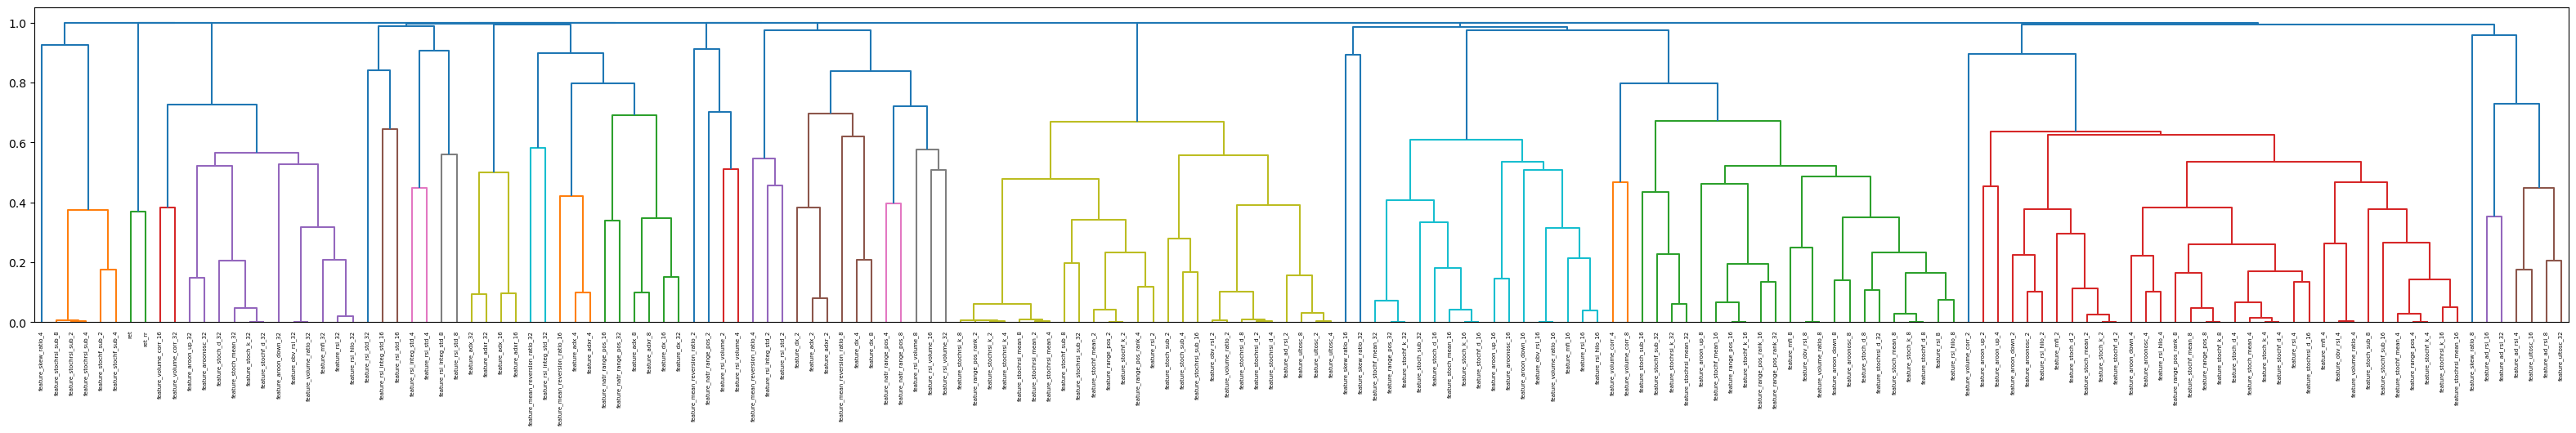

In [205]:
# https://www.kaggle.com/code/sgalella/correlation-heatmaps-with-hierarchical-clustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(40,5))
dissimilarity = 1 - abs(corr)
dissimilarity = dissimilarity.dropna(axis=0, how='all').dropna(axis=1, how='all')
print(dissimilarity.shape)
# display(dissimilarity)
# display(dissimilarity.values - dissimilarity.values.T)
Z = linkage(squareform(dissimilarity, checks=False), 'complete')

dendrogram(Z, labels=dissimilarity.columns, orientation='top',
           leaf_rotation=90)
plt.show()